In [1]:
%run ../python/oana_setup.py
%matplotlib inline

/hdd500/home/e16e1fjobssimtof/e1f/skim/3????.root
/hdd500/home/e16e1fjobssimtof/e1f/skim/3xxxx_run.root
run.lum(=l)
runb.lb(=l)
tpipf.tpilf(=lf)
h10.tpipf(=pf)
h10.run(=r)
h10.tkin(=k)
elist_fid_mm_[123]=el[123]
loaded acc.cpp
loaded fid.cpp
loaded particle-constants.h
loaded Fid instance
loaded infid.C
loaded eff.cpp
recompiling h10t3pi_sel.C...
... done.
Fid::Instance() loaded	 from /home/ephelps/dropbox/barracuda_copy-gmail/phys-ana-omega/fid.cpp	 with parameters from /home/ephelps/dropbox/barracuda_copy-gmail/phys-ana-omega/input/fid.parms
infid() loaded	 from /home/ephelps/dropbox/barracuda_copy-gmail/phys-ana-omega/infid.C
h10 aliases: c, mpip, bifpip, dtifpip, sf	fidpass, fidpass[e,p,pip,pim]	top[1,2,3]pass, mmthreshpass, mmpi0pass	ccpass


In [2]:
import rootpy as rp
from numpy import arange, linspace
import numpy as np
from scipy import interpolate
import math
import os
MASS_P = 0.93827203
tops = {1:(el1, 'xsect_manual.root')}
top = 1    # default to topology 1
h10.SetEntryList(el1)

def create_hists(fn=tops[top][1], el=tops[top][0]):
    global h10
    h10.SetEntryList(el)
    ht1q2w = rh1('-t1:Q2:W', hn='ht1q2w', cutstr='1/(accw8(W, Q2, ct, phi)*vgflux*0.891*19.844e6)', binning='(32,1.6,3.2, 9,1.0,5.5, 80,0,8)')
    hmq2w = rh1('mmp:Q2:W', hn='hmq2w', cutstr='1/(accw8(W, Q2, ct, phi)*vgflux*0.891*19.844e6)', binning='(32,1.6,3.2, 9,1.0,5.5, 80, 0.4, 1.2)')
    hq2w = rh1('Q2:W', hn='hq2w', cutstr='1/(accw8(W, Q2, ct, phi)*vgflux*0.891*19.844e6)', binning='(320,1.6,3.2, 80,1,5.5)')
    #with ropen('simulation_shaping.root', 'recreate') as fout:
    with ropen(fn, 'recreate') as fout:
        [h.Clone().Write(h.GetName()) for h in [ht1q2w, hmq2w, hq2w]]
    return (ht1q2w, hmq2w, hq2w)

def get_hists(fn=tops[top][1], el=tops[top][0]):
    global h10
    h10.SetEntryList(el)
    ht1q2w, hmq2w, hq2w = _,_,_
    if (os.path.exists(fn)):
        with ropen(fn, 'read') as fin:
            ht1q2w, hmq2w, hq2w = [asrootpy(h.Clone()) for h in [fin.ht1q2w, fin.hmq2w, fin.hq2w]]
            [h.SetDirectory(0) for h in [ht1q2w, hmq2w, hq2w]]
            fin.Close()
    else:
        ht1q2w, hmq2w, hq2w = create_hists(fn, el)
    return (ht1q2w, hmq2w, hq2w)

ht1q2w, hmq2w, hq2w = get_hists()

def get_projs(h3=hmq2w, hntmpl='mass_%d_%d', zintrange=(0.750, 0.793), minint=1000):
    wax, q2ax, zax = h3.GetXaxis(), h3.GetYaxis(), h3.GetZaxis()
    zlobin, zhibin = zax.FindBin(zintrange[0]), zax.FindBin(zintrange[1])+1
    hms = [asrootpy(h3.ProjectionZ(hntmpl%(1000*wax.GetBinCenter(wbin), 1000*q2ax.GetBinCenter(q2bin)),
                                    wbin, wbin+1, q2bin, q2bin+1))
            for q2bin in range(1, q2ax.GetNbins())
            for wbin in range(1, wax.GetNbins())
            if h3.Integral(wbin, wbin+1, q2bin, q2bin+1, zlobin, zhibin) > minint]
        
    zax.SetRange(0,-1)
    return hms

def bgfun(x, p):
    pol2 = p[0]+p[1]*x[0]+p[2]*x[0]*x[0]
    #print(p[3], x[0], p[4])
    drop = 1 - math.erf((x[0]-p[3])/p[4])
    if (x[0] > 0.5 and x[0] < 0.6) or (x[0] > 0.7 and x[0] < 0.92): r.TF1.RejectPoint()
    return pol2*drop/2

def drop(x, p):
    return 1 - math.erf((x[0]-p[0])/p[1])

def gausdrop(x, p):
    gaus = p[0]*math.exp(-0.5*pow(((x[0]-p[1])/p[2]), 2))
    return gaus*drop(x, [p[3],p[4]])/2

def fitfun(x, p):
    pol2 = p[0]+p[1]*x[0]+p[2]*x[0]*x[0]
    gaus = p[5]*math.exp(-0.5*pow(((x[0]-p[6])/p[7]), 2))
    return (gaus+pol2)*drop(x, [p[3],p[4]])/2
def fit_mmp(h, fout=None):
    '''
    Fit histogram with (gauss+pol2)*(erf cutoff).
    Return tuple of W, Q2, histogram, function, fit parameters, chi2, FCstatu.
    + Cutoff parameters estimated from phase space edge from W.
    + Background parameters estimated by fitting with signal, skipping signal region.
    + Signal parameters estimated by subtracting initial background and fitting in
      vicinity of the omega mass mean.
    + Full histogram fitted with combined function.
    TODO:  add option to provide initial parameter estimates.
    '''
    result = []
    # ######### get W,Q2 bin information
    W, Q2 = h.GetName().split('_')[1:]
    W = float(W)/1000.0
    Q2 = float(Q2)/1000.0
    wlow, whigh = W-0.025, W+0.025  # W bins are 50 MeV
    # ######### calculate MMp phase space edge range
    mmpax = h.GetXaxis()
    x0 = math.sqrt(wlow**2+MASS_P**2-2*wlow*MASS_P)
    x1 = math.sqrt(whigh**2+MASS_P**2-2*whigh*MASS_P)
    # ######### setup fit functions
    fgaus = r.TF1('fgaus', gausdrop, 0.4, 1.2, 5)
    fgaus.SetParameters(r.Double(20), r.Double(0.783), r.Double(0.20), r.Double((x1+x0)*0.5), r.Double(x1-x0))
    fgaus.SetParLimits(0, 0.01, 1e4)
    fgaus.SetParLimits(1, 0.773, 0.793)
    fgaus.SetParLimits(2, 0.011, 0.035)
    fgaus.SetParLimits(3,x0+(x1-x0)/4,x1-(x1-x0)/4)
    fgaus.SetParLimits(4,0.15*(x1-x0), 2*(x1-x0))
    fbg = r.TF1('fbg', bgfun, 0.4, 1.2, 5)
    fbg.SetParameters(r.Double(0), r.Double(0), r.Double(0.02), r.Double((x1+x0)*0.5), r.Double(x1-x0))
    fbg.SetParLimits(3,x0+(x1-x0)/4,x1-(x1-x0)/4)
    fbg.SetParLimits(4,0.15*(x1-x0), 2*(x1-x0))
    fbg.SetParLimits(2, 0.01, 1e9)
    # ######### fit background for parameter estimates
    h.Fit(fbg, '', 'goff', 0.4, 1.2)
    if True:  #r.gMinuit.fCstatu.startswith('CONV'):
        # ######### fit signal for parameter estimates
        wsig = h.Clone()
        wsig.Add(fbg, -1)
        sigint = wsig.Integral(mmpax.FindBin(0.76), mmpax.FindBin(0.80))
        sigint = sigint if sigint > 0 else h.Integral(mmpax.FindBin(0.76), mmpax.FindBin(0.80))
        fgaus.SetParLimits(0, 0.1*sigint, 2*sigint)
        wsig.Fit(fgaus, '', '', 0.76, 0.80)
        if True:  #r.gMinuit.fCstatu.startswith('CONV'):
            # ######### create combined signal-background function and set parameters
            fsigbg = r.TF1('fsigbg', fitfun, 0.4, 1.2, 8)
            fsigbg.SetParameters(r.Double(0), r.Double(0), r.Double(0.02), r.Double((x1+x0)*0.5), r.Double(x1-x0), r.Double(20), r.Double(0.783), r.Double(0.022))
            fsigbg.SetParameters(fbg.GetParameter(0), fbg.GetParameter(1), fbg.GetParameter(2),
                                 fbg.GetParameter(3), fbg.GetParameter(4),
                                 fgaus.GetParameter(0), fgaus.GetParameter(1), fgaus.GetParameter(2))
            fsigbg.SetParLimits(2, 0.0001, 1e9)
            fsigbg.SetParLimits(3,x0+(x1-x0)/4,x1-(x1-x0)/4)
            fsigbg.SetParLimits(4,0.15*(x1-x0), 2*(x1-x0))
            #fsigbg.SetParLimits(3,0.65,2)
            #fsigbg.SetParLimits(4,0.03, 0.2)
            fsigbg.SetParLimits(5, 0.1*sigint, 2*sigint)
            fsigbg.SetParLimits(6, 0.773, 0.793)
            fsigbg.SetParLimits(7, 0.011, 0.035)
            # ######### fit signal and background
            h.Fit(fsigbg, '', 'goff', 0.4, 1.2)
            if True:  #r.gMinuit.fCstatu.startswith('CONV'):
                q = fsigbg.GetChisquare()/fsigbg.GetNDF() if fsigbg.GetNDF() > 0 else -1
                result += [W,Q2]
                result.append(h)
                result.append(h.GetListOfFunctions()[0])
                result.append(tuple([fsigbg.GetParameter(ipar) for ipar in range(0,8)]))
                result.append(q)
                result.append(r.gMinuit.fCstatu)
                if fout is not None: fout.WriteObject(h, h.GetName())
    return tuple(result) if result is not None else None

ERROR:ROOT.TChain.SetEntryList] No list found for the trees in this chain
ERROR:ROOT.TChain.SetEntryList] No list found for the trees in this chain


In [3]:
hms = get_projs(hmq2w, minint=0)
[h.Scale(1/0.025) for h in hms]
fout = ropen('xsect_manual_bgfits.root','recreate')
results = [result for result in [fit_mmp(h, fout) for h in hms] if result is not None]

INFO:ROOT.TCanvas.MakeDefCanvas]  created default TCanvas with name c1


132:25:157


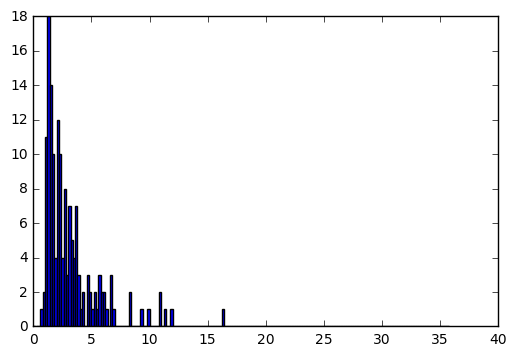

In [4]:
plt.hist([result[5] for result in results], bins=arange(0,36,0.2))
# hbads = [res for res in results if not res[4].startswith('CONV') or res[3] > 5]
# hgoods = [res for res in results if not (not res[4].startswith('CONV') or res[3] > 5)]
hbads = [res for res in results if res[5] > 5]
hgoods = [res for res in results if not res[5] > 5]
print('%d:%d:%d' % (len(hgoods), len(hbads), len(results)))

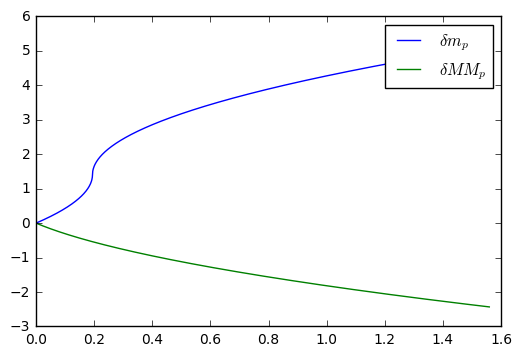

In [12]:
#rc('text', usetex=True)
MASS_E, MASS_P = 5.11e-4, 0.9382720
lvE0, lvE1, lvP0, lvP1 = r.TLorentzVector(), r.TLorentzVector(), r.TLorentzVector(), r.TLorentzVector()
lvE0.SetXYZM(0, 0, 5.497, MASS_E)
lvE1.SetXYZM(-0.530879,0.5977996,1.6425339,MASS_E)
lvP0.SetXYZM(0,0,0,MASS_P)
lvP1.SetXYZM(0.2381055,0.0006208,1.5412714,MASS_P)
def lvLoss(deltaE):
    ret = r.TLorentzVector()
    ret.SetXYZM(0,0,-deltaE, 0)
    return ret
lvq = lvE0-lvE1
lvw = lvq+lvP0
mmp = (lvw-lvP1).M()
X = linspace(0,lvP1.P(),1000)
X = list(zip(X,X))
Y = [(mmp-(lvw-lvP1-lv).M(),MASS_P-(lvP1+lv).M()) for lv in [lvLoss(dE[0]) for dE in X]]
plt.plot(X,Y)
plt.legend([r'$\delta m_{p}$', r'$\delta MM_{p}$'])

0.784151810469 0.0231427435038


TypeError: unorderable types: float() > NoneType()

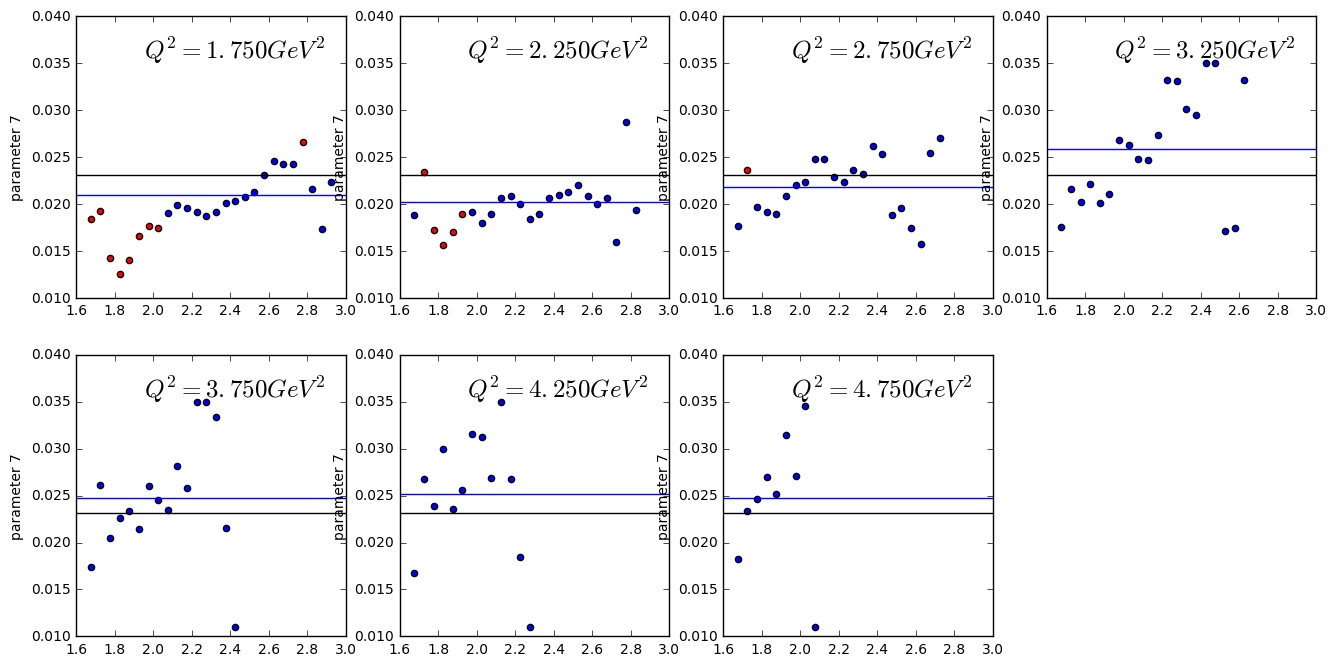

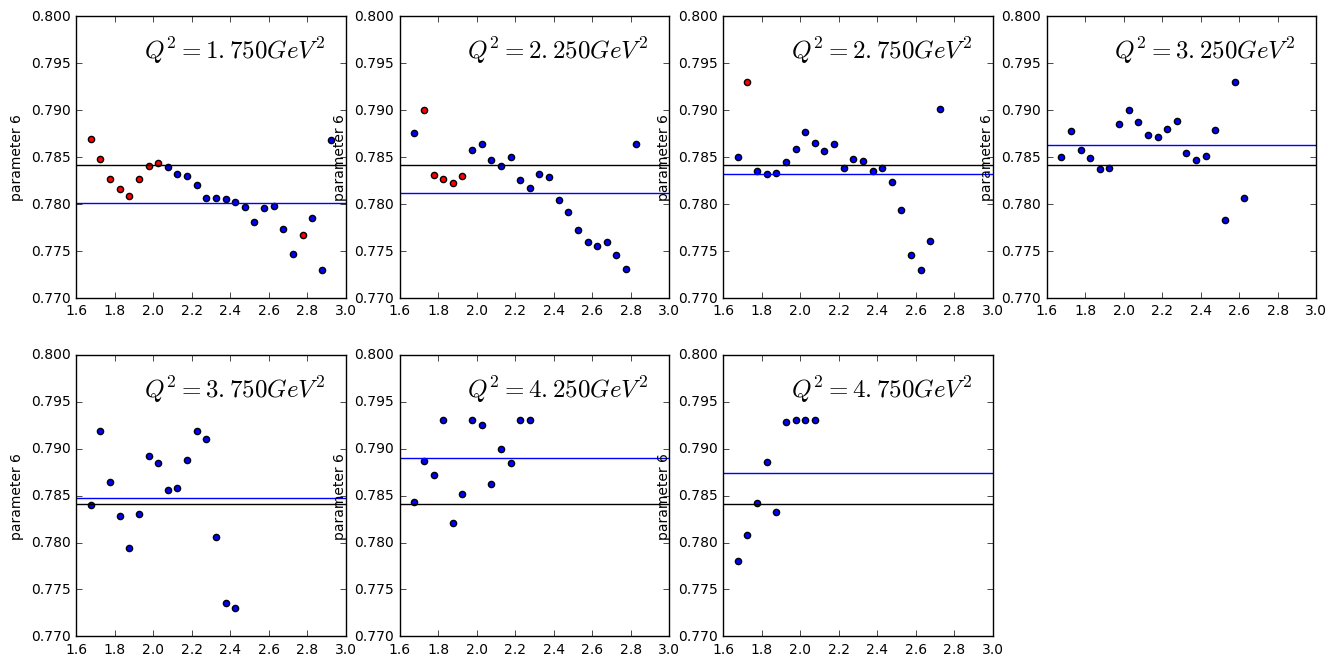

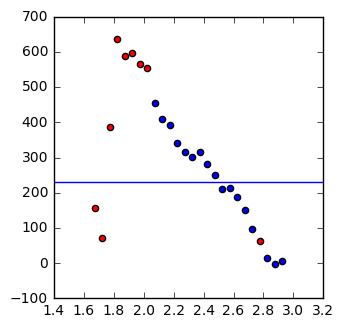

In [22]:
q2s = np.unique([h[1] for h in hgoods if h[1]>=1.5])
ws = np.unique([h[0] for h in hgoods if h[1]>=1.5])
colorcycle = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
sigmas = [s for s in [h[4][7] for h in hgoods if h[1] in q2s]]
masses = [s for s in [h[4][6] for h in hgoods if h[1] in q2s]]
avgS = np.average(sigmas)
avgM = np.average(masses)
print(avgM,avgS)
def drawparms(ipar, avg=None, ylims=None, xlims=(1.6,3.0), fig=None):
    for i, q2 in enumerate(q2s):
        if fig is None: fig = plt.figure(figsize=(16,8))
        ax = fig.add_subplot(2,4,i+1)
        W = [w for w in [h[0] for h in hgoods if h[1]==q2]]
        S = [s for s in [h[4][ipar] for h in hgoods if h[1]==q2]]
        plt.scatter(W, S, c='b')
        plt.axhline(np.average(S), color='b')
        W = [w for w in [h[0] for h in hbads if h[1]==q2]]
        S = [s for s in [h[4][ipar] for h in hbads if h[1]==q2]]
        plt.scatter(W, S, c='r')
        plt.axhline(avg, color='k')
        if ylims is not None: plt.ylim(*ylims)
        plt.xlim(*xlims)
        plt.ylabel('parameter %d'%ipar)
        plt.text(0.25, 0.85, '$Q^{2} = %.3f GeV^{2}$'%q2, fontsize=18, transform=ax.transAxes)

fig = plt.figure(1, figsize=(16,8))
drawparms(7, avgS, (0.01,0.04))
fig2 = plt.figure(2, figsize=(16,8))
drawparms(6, avgM, (0.77,0.8))
for ipar in range(0,6):
    drawparms(ipar)
